In [4]:
%reset -f

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [6]:
import scipy.stats

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [8]:
import collections

In [9]:
import pickle

In [10]:
import bridson

In [11]:
import sklearn.preprocessing
import sklearn.model_selection

In [12]:
import uproot
uproot.default_library = "np"

In [13]:
import os.path

In [14]:
import logging
logging.basicConfig(level=logging.INFO)

In [15]:
np.set_printoptions(precision=4, suppress=True)

In [16]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [17]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [18]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [19]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [20]:
class DataFile(object):
    def __init__(self, path, name, aliases={}):
        self.path = path
        self.name = name
        self.aliases = aliases
        self.raw = uproot.open(self.path)
    def features(self):
        return sorted(list(set(list(self.raw.keys()) + list(self.aliases.keys()))))
    def true_features(self):
        return [name for name in self.features() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=(self.aliases|aliases), library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [21]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [22]:
tree_names_nohits = [
    "RapidSim/B2Kee_tree.root:DecayTree;29",
    "RapidSim/B2KJpsi2ee_tree.root:DecayTree;36",
    "RapidSim/B2Kpsi2s2ee_tree.root:DecayTree;37",
    "RapidSim/D2phipi2ee_tree.root:DecayTree;31",
]

In [23]:
tree_names_hits = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [24]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names_nohits, channel_names)]

In [25]:
files[3].aliases = {
    'B_FD': "D_FD",
    'B_FD_TRUE': "D_FD_TRUE",
}

In [26]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['B_FD_TRUE',
 'angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [27]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [28]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [29]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2, true=True):
    feature = "q2_TRUE" if true else "q2"
    return join_and("%s > %g" % (feature, v1), "%s < %g" % (feature, v2))

In [30]:
def e_selectors(true=True):
    q_Kll_selector = q2_range(1.1, 6.0, true)
    q_Jpsi_e_selector = q2_range(6.0, 12.96, true)
    q_psi2S_e_selector = q2_range(9.82, 16.40, true)
    selectors = [
        q_Kll_selector,
        q_Jpsi_e_selector,
        q_psi2S_e_selector,
        "True",
    ]
    return selectors

#q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [31]:
selectors_true = e_selectors(True)
selectors_notrue = e_selectors(False)

In [32]:
selected_true = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_true)]
selected_notrue = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors_notrue)]

In [33]:
splitted_true = [split(f, shuffle=True, test_size=0.2) for f in selected_true]
train_ds_true = [x[0] for x in splitted_true]
test_ds_true = [x[1] for x in splitted_true]

In [34]:
splitted_notrue = [split(f, shuffle=True, test_size=0.2) for f in selected_notrue]
train_ds_notrue = [x[0] for x in splitted_notrue]
test_ds_notrue = [x[1] for x in splitted_notrue]

In [35]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected_true:
    df.loc[f.name(), "Selected true"] = len(f)
for f in train_ds_true:
    df.loc[f.name(), "Train true"] = len(f)
for f in test_ds_true:
    df.loc[f.name(), "Test true"] = len(f)
for f in selected_notrue:
    df.loc[f.name(), "Selected notrue"] = len(f)
for f in train_ds_notrue:
    df.loc[f.name(), "Train notrue"] = len(f)
for f in test_ds_notrue:
    df.loc[f.name(), "Test notrue"] = len(f)
df["Selected/Total true"] = df["Selected true"] / df["Total"]
df["Selected/Total notrue"] = df["Selected notrue"] / df["Total"]
df

#Events             Total  Selected true  Train true  Test true  \
B⁺→K⁺ee          970116.0       247104.0    197683.0    49421.0   
B⁺→K⁺J/ψ(→ee)    960234.0       929755.0    743804.0   185951.0   
B⁺→K⁺ψ(2S)(→ee)  986271.0       939679.0    751743.0   187936.0   
D⁺→π⁺φ(→ee)      830027.0       830027.0    664021.0   166006.0   

#Events          Selected notrue  Train notrue  Test notrue  \
B⁺→K⁺ee                 296675.0      237340.0      59335.0   
B⁺→K⁺J/ψ(→ee)           845739.0      676591.0     169148.0   
B⁺→K⁺ψ(2S)(→ee)         768614.0      614891.0     153723.0   
D⁺→π⁺φ(→ee)             830027.0      664021.0     166006.0   

#Events          Selected/Total true  Selected/Total notrue  
B⁺→K⁺ee                     0.254716               0.305814  
B⁺→K⁺J/ψ(→ee)               0.968259               0.880763  
B⁺→K⁺ψ(2S)(→ee)             0.952759               0.779313  
D⁺→π⁺φ(→ee)                 1.000000               1.000000

### KS tests

In [36]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [37]:
perform_ks_test(train_ds_notrue, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [38]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        try:
            plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
                density=True, histtype='step', bins=bins, **kwargs)
        except:
            pass
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
aliases = {
    "min_e_IP_TRUE": "fmin(ep_IP_TRUE,em_IP_TRUE)",
    "max_e_PT_TRUE": "fmax(ep_PT_TRUE,em_PT_TRUE)",
    "max_e_SIGMAIP_TRUE": "fmax(ep_SIGMAIP_TRUE,em_SIGMAIP_TRUE)",
    "max_e_P_TRUE": "fmax(ep_P_TRUE,em_P_TRUE)",
    
    "min_e_IP": "fmin(ep_IP,em_IP)",
    "max_e_PT": "fmax(ep_PT,em_PT)",
    "max_e_P": "fmax(ep_P,em_P)",
}

In [40]:
def features_plots(ds):
    feature_plot("log(B_FD)", ds, aliases, 101)
    feature_plot("log(max_e_SIGMAIP_TRUE)", ds, aliases, 101)
    feature_plot("log(angle_ee)", ds, aliases, 101)
    feature_plot("log(min_e_IP)", ds, aliases, 101)
    feature_plot("log(max_e_PT)", ds, aliases, 101)
    feature_plot("log(max_e_P)", ds, aliases, 101)

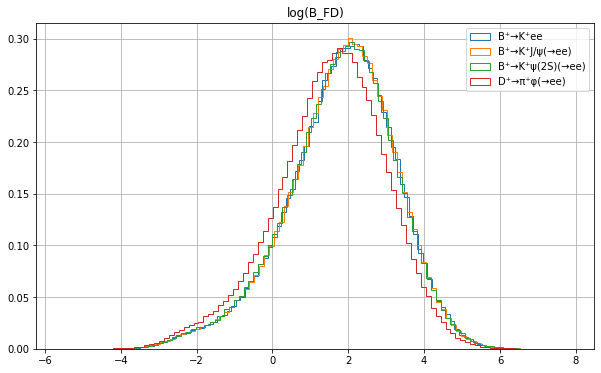

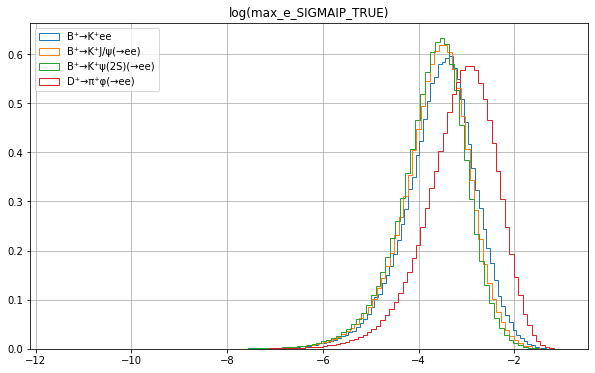

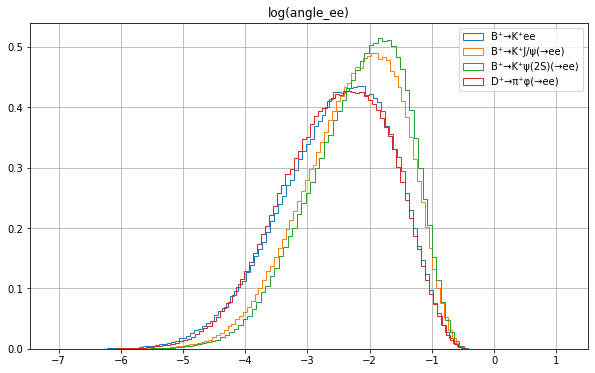

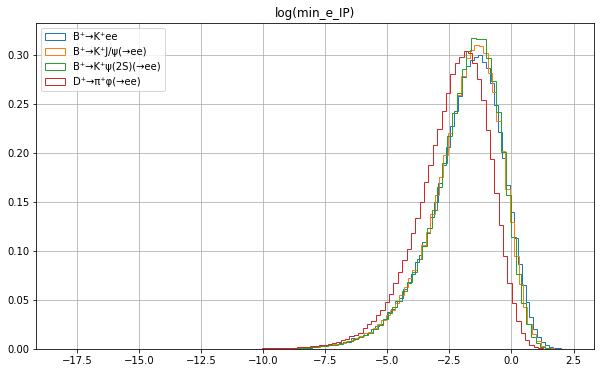

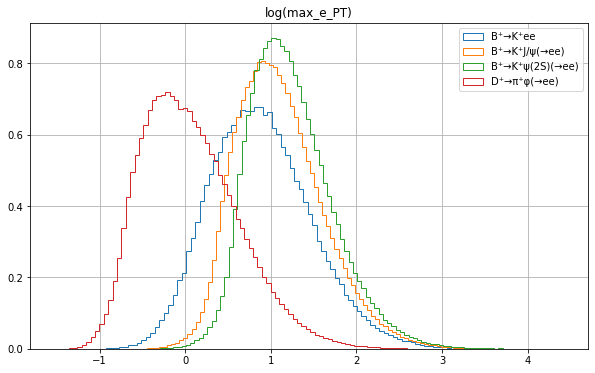

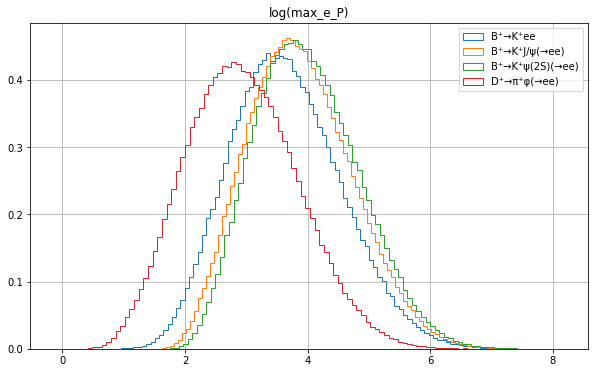

In [41]:
features_plots(train_ds_notrue)

### Preprocessing

In [42]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [43]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [93]:
features = ["log(angle_ee)", "log(B_FD)", "log(min_e_IP)", "log(max_e_SIGMAIP_TRUE)"]
feature_sets = [("%dp"%(i+2), ["log(max_e_P)"] + features[:i+1]) for i in range(0, len(features))] \
             + [("%d"%(i+2), ["log(max_e_PT)"] + features[:i+1]) for i in range(0, len(features))]
    
train_datasets = [
    ("₄", train_ds_notrue),
    ("₃", train_ds_notrue[:3]),
]

test_datasets = [
    ("₄", test_ds_notrue),
    ("₃", test_ds_notrue[:3]),
]

all_datasets = list()
val_datasets = list()
for f in feature_sets:
    for t, v in zip(train_datasets, test_datasets):
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
        val_datasets.append(Dataset(f[1], v[1], aliases, "V%s[%s]"%(v[0],f[0])))

In [94]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [95]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

In [96]:
#fig, ax = plt.subplots(3, 2, figsize=(10, 15))
#for i in range(6):
#    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
#plt.show()

### NN

In [107]:
class Logger:
    def __init__(self, name=None):
        self.measurements = [{}]
        self.name = name
    def last(self):
        return self.measurements[-1]
    def log(self, **kwargs):
        self.measurements.append(kwargs)
    def update(self, **kwargs):
        self.last().update(kwargs)
    def extract(self, key, default=None, skip=True):
        index = list()
        result = list()
        for i, entry in enumerate(self.measurements):
            value = entry.get(key, default)
            if not (skip and value is None):
                index.append(i)
                result.append(value)
        return index, result

In [108]:
def model(inputs, outputs, hid=20):
    return nn.Sequential(
        nn.Linear(inputs, hid), nn.Softplus(),
        nn.Linear(hid, hid), nn.Softplus(),
        nn.Linear(hid, hid), nn.Softplus(),
        nn.Linear(hid, outputs),
    )

In [109]:
def train(model, loader, epochs=20, weight=None, accumulate=False, logger=None, val_loader=None):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss.item()
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        
        val_loss = None
        if val_loader is not None:
            model.eval()
            val_total_loss = 0
            val_count = 0
            for batch in loader:
                x, y = batch
                pred = model(x)
                loss = F.cross_entropy(
                    input=pred,
                    target=y,
                    weight=wt,
                    reduction='sum',
                )
                val_total_loss += loss.item()
                val_count += x.shape[0]
                val_loss = val_total_loss/val_count
            model.train()
        if logger is None:
            logging.info("Epoch %d, %f", epoch, mean_loss)
        else:
            logger.log(mean_loss=mean_loss, val_loss=val_loss)
    model.eval()
    model.zero_grad(set_to_none=True)
    return model

### Weight limits estimation

In [110]:
def train_estimator(dataset, model, device=device, logger=None, val_dataset=None, batch_size=100000, batch_epochs=50, full_epochs=50):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    val_loader = None
    if val_dataset is not None:
        vds = torch.utils.data.TensorDataset(
            val_dataset.X(device=device, dtype=float),
            val_dataset.Y(device=device, dtype=torch.int64)
        )
        val_loader = Loader(vds, batch_size=batch_size, shuffle=False, device=device)
    loader = Loader(ds, batch_size=batch_size, shuffle=True, device=device)
    train(model, loader, epochs=batch_epochs, weight=dataset.weights, accumulate=False, logger=logger, val_loader=val_loader)
    loader = Loader(ds, batch_size=batch_size, shuffle=False, device=device)
    train(model, loader, epochs=full_epochs, weight=dataset.weights, accumulate=True, logger=logger, val_loader=val_loader)
    return model.eval()

In [111]:
def make_estimator(dataset, device=device, hid=20):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources), hid=hid)
    return torch.nn.Sequential(scaler, m).to(device)

In [112]:
%%time
all_est = list()
all_log = list()
for ds, vds in zip(all_datasets, val_datasets):
    logger = Logger(name="Est%s"%ds.name)
    est = make_estimator(ds)
    train_estimator(ds, est, logger=logger, val_dataset=vds)
    all_est.append(est)
    all_log.append(logger)
    logging.info("Done %s, %s", logger.name, logger.last())

INFO:root:Done Est₄[2p], {'mean_loss': 0.822538860297454, 'val_loss': 0.8225201720152788}
INFO:root:Done Est₃[2p], {'mean_loss': 0.8222740720674153, 'val_loss': 0.8222262027969901}
INFO:root:Done Est₄[3p], {'mean_loss': 0.8212390012930703, 'val_loss': 0.8212334844109906}
INFO:root:Done Est₃[3p], {'mean_loss': 0.8196201624109936, 'val_loss': 0.8196020661148747}
INFO:root:Done Est₄[4p], {'mean_loss': 0.7635692159248291, 'val_loss': 0.7635469809483625}
INFO:root:Done Est₃[4p], {'mean_loss': 0.8095650631049592, 'val_loss': 0.8095347931691852}
INFO:root:Done Est₄[5p], {'mean_loss': 0.7415645946694542, 'val_loss': 0.7415485089590317}
INFO:root:Done Est₃[5p], {'mean_loss': 0.8002434418767358, 'val_loss': 0.8002088155435197}
INFO:root:Done Est₄[2], {'mean_loss': 1.0185858395357077, 'val_loss': 1.0185786802366836}
INFO:root:Done Est₃[2], {'mean_loss': 0.998251840305804, 'val_loss': 0.9982397164900492}
INFO:root:Done Est₄[3], {'mean_loss': 1.0054050445300917, 'val_loss': 1.0053974915497825}
INFO

CPU times: user 11min 58s, sys: 2.57 s, total: 12min
Wall time: 11min 57s


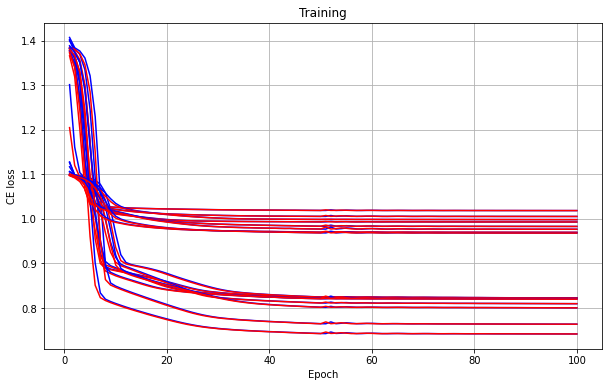

In [114]:
for logger in all_log:
    plt.plot(*logger.extract("mean_loss"), label=logger.name, color="b")
    plt.plot(*logger.extract("val_loss"), label=logger.name, color="r")
plt.title("Training")
plt.ylabel("CE loss")
plt.xlabel("Epoch")
plt.grid()
#plt.legend()
plt.show()

In [115]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [116]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [117]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [118]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

In [119]:
if False:
    fig, ax = plt.subplots(6, 3, figsize=(15, 30))
    for i in range(6):
        est = all_est[i]
        ds = all_datasets[i]
        plot_ds(ds, scaler=est[0], ax=ax[i,0])
        plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
    plt.show()

### Weighting function

In [120]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [121]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [122]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [123]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [124]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [127]:
def fix_linear(model, loader, n_outs, n_classes, selected_class):
    with torch.no_grad():
        W, counts = create_w(model[:3], loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, model[3], selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", to_numpy(model[3].weight.data))    

In [134]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None, logger=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0
            total_loss_c = 0
            total_loss_d = 0
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss_c = loss_c.item()
                total_loss_d = loss_d.item()
                total_loss += loss.item()
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            if logger is None:
                print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
            else:
                logger.log(
                    total_loss=total_loss,
                    loss_c=total_loss_c,
                    loss_d=total_loss_d,
                    L=L,
                    det=det,
                    W=W_np,
                    W_pinv=W_pinv,
                )
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    fix_linear(model, loader, n_outs, n_classes, selected_class)
    return model

In [135]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, logger=None, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001, logger=logger)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, logger=logger, **kwargs)
    #fix_linear(model, loader, n_outs, n_classes, selected_class)
    return model.eval()

In [136]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, logger=None, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, logger=logger, **kwargs)
    
    def fix_linear(self, dataset, selected_class=0):
        loader = Loader(dataset, batch_size=100000, shuffle=False, device=device)
        fix_linear(self.model, loader, self.n_outs, self.n_classes, selected_class)

In [137]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [139]:
%%time
results = dict()
loggers = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        logger = Logger(name=name)
        w.train(ds, target_L=target_L, logger=logger)
        results[target_L, ds.name] = w
        loggers[target_L, ds.name] = logger
        logging.info("%s, %s", name, logger.last())

W= [[0.3791 0.1124 0.0487 0.2681]
 [0.2064 0.3024 0.2213 0.0295]
 [0.2377 0.5748 0.7283 0.0086]
 [0.1768 0.0104 0.0017 0.6938]]
W+= [[ 4.4467 -2.4582  0.4534 -1.6192]
 [-4.4419 10.3049 -2.8376  1.3129]
 [ 2.0664 -7.3356  3.4653 -0.5291]
 [-1.0712  0.4889 -0.0811  1.8354]]
L= 0.7801247239112854
coef= [[0.1589 0.     0.003  0.0395]]


INFO:root:w₄[2p]@None, {'total_loss': -12.624387547373772, 'loss_c': 2.805236726999283e-05, 'loss_d': -0.13948151469230652, 'L': 7.618878364562988, 'det': 0.0003736503, 'W': array([[0.1647, 0.0065, 0.0004, 0.0816],
       [0.403 , 0.4938, 0.3258, 0.068 ],
       [0.1919, 0.4993, 0.6738, 0.0036],
       [0.2405, 0.0004, 0.    , 0.8467]], dtype=float32), 'W_pinv': array([[ 7.4502, -0.1837,  0.0848, -0.7033],
       [-8.6008,  4.1739, -2.0136,  0.5017],
       [ 4.2626, -3.0406,  2.952 , -0.1789],
       [-2.1121,  0.0504, -0.0232,  1.3805]], dtype=float32)}


W= [[0.1647 0.0065 0.0004 0.0816]
 [0.403  0.4938 0.3257 0.068 ]
 [0.1919 0.4993 0.6739 0.0036]
 [0.2405 0.0004 0.     0.8468]]
W+= [[ 7.4491 -0.1835  0.0847 -0.7031]
 [-8.599   4.1734 -2.0123  0.5015]
 [ 4.2616 -3.0402  2.9508 -0.1788]
 [-2.1117  0.0503 -0.0232  1.3804]]
L= 7.625384330749512
coef= [[0.8339 0.0292 0.0003 0.    ]]
W= [[0.5686 0.1592 0.0896]
 [0.2379 0.374  0.3205]
 [0.1935 0.4668 0.5899]]
W+= [[ 2.2635 -1.6599  0.5579]
 [-2.4969 10.1352 -5.1271]
 [ 1.2334 -7.4753  5.5692]]
L= 0.48515093326568604
coef= [[0.1256 0.     0.    ]]


INFO:root:w₃[2p]@None, {'total_loss': -4.9658456817269325, 'loss_c': 3.1416129786521196e-07, 'loss_d': -0.04654479771852493, 'L': 6.49340295791626, 'det': 0.0019922373, 'W': array([[0.3099, 0.0027, 0.0006],
       [0.4843, 0.4914, 0.3462],
       [0.2058, 0.5058, 0.6532]], dtype=float32), 'W_pinv': array([[ 3.2684, -0.0328,  0.0142],
       [-5.4913,  4.5323, -2.3969],
       [ 3.2229, -3.4996,  3.3827]], dtype=float32)}


W= [[0.31   0.0027 0.0006]
 [0.4842 0.4912 0.3459]
 [0.2059 0.5061 0.6535]]
W+= [[ 3.2679 -0.0327  0.0141]
 [-5.4895  4.532  -2.3934]
 [ 3.2217 -3.4993  3.3793]]
L= 6.49642276763916
coef= [[1.     0.0352 0.    ]]
W= [[0.3718 0.0963 0.0427 0.2786]
 [0.2213 0.3164 0.2226 0.0327]
 [0.2392 0.5787 0.7337 0.0086]
 [0.1677 0.0086 0.0011 0.6801]]
W+= [[ 4.3538 -1.8411  0.3074 -1.699 ]
 [-4.3776  8.9673 -2.4673  1.3932]
 [ 2.0451 -6.4765  3.2093 -0.5668]
 [-1.0214  0.3502 -0.0495  1.8726]]
L= 0.9733871817588806
coef= [[0.1903 0.     0.0025 0.0249]]


INFO:root:w₄[3p]@None, {'total_loss': -12.553501889109612, 'loss_c': 3.215298056602478e-05, 'loss_d': -0.13943949341773987, 'L': 6.360193729400635, 'det': 0.00035794027, 'W': array([[0.1641, 0.0067, 0.0004, 0.081 ],
       [0.4063, 0.4967, 0.3316, 0.0695],
       [0.1913, 0.4962, 0.668 , 0.004 ],
       [0.2383, 0.0004, 0.    , 0.8455]], dtype=float32), 'W_pinv': array([[ 7.4752, -0.1893,  0.0891, -0.7008],
       [-8.7282,  4.2146, -2.0866,  0.4997],
       [ 4.3554, -3.0767,  3.0216, -0.1788],
       [-2.1024,  0.0514, -0.0242,  1.38  ]], dtype=float32)}


W= [[0.1641 0.0067 0.0004 0.081 ]
 [0.4063 0.4967 0.3315 0.0695]
 [0.1913 0.4963 0.6681 0.004 ]
 [0.2383 0.0004 0.     0.8455]]
W+= [[ 7.4743 -0.1892  0.089  -0.7006]
 [-8.7268  4.2143 -2.0852  0.4994]
 [ 4.3546 -3.0765  3.0203 -0.1787]
 [-2.1021  0.0514 -0.0241  1.3799]]
L= 6.364622592926025
coef= [[0.8398 0.0288 0.0001 0.    ]]
W= [[0.5732 0.165  0.1021]
 [0.2469 0.3963 0.3378]
 [0.1799 0.4387 0.5601]]
W+= [[ 2.2169 -1.4308  0.4587]
 [-2.3292  9.0929 -5.0586]
 [ 1.1122 -6.6621  5.5998]]
L= 0.6109427213668823
coef= [[0.1212 0.     0.    ]]


INFO:root:w₃[3p]@None, {'total_loss': -5.072601098567247, 'loss_c': 1.712905941531062e-07, 'loss_d': -0.046506788581609726, 'L': 7.577666282653809, 'det': 0.0026794525, 'W': array([[0.3253, 0.0031, 0.0015],
       [0.4939, 0.5277, 0.3672],
       [0.1808, 0.4693, 0.6313]], dtype=float32), 'W_pinv': array([[ 3.1066, -0.0237,  0.0064],
       [-4.7416,  3.9621, -2.2931],
       [ 2.635 , -2.9384,  3.2867]], dtype=float32)}


W= [[0.3253 0.0031 0.0015]
 [0.4938 0.5275 0.3669]
 [0.1809 0.4695 0.6316]]
W+= [[ 3.1062 -0.0237  0.0064]
 [-4.7405  3.9621 -2.2904]
 [ 2.6343 -2.9384  3.284 ]]
L= 7.580385684967041
coef= [[1.     0.0321 0.    ]]
W= [[0.4218 0.1656 0.0845 0.1774]
 [0.2168 0.3508 0.2843 0.0165]
 [0.1921 0.4716 0.63   0.002 ]
 [0.1693 0.0119 0.0013 0.804 ]]
W+= [[ 3.7484 -2.72    0.7262 -0.7732]
 [-3.4498  9.7589 -3.9417  0.5707]
 [ 1.4419 -6.4776  4.3169 -0.196 ]
 [-0.7404  0.4386 -0.1015  1.3984]]
L= 0.5263726115226746
coef= [[0.1156 0.     0.0002 0.0615]]


INFO:root:w₄[4p]@None, {'total_loss': -9.706964194774628, 'loss_c': 1.3751676306128502e-05, 'loss_d': -0.1395949423313141, 'L': 6.537096977233887, 'det': 0.00041627232, 'W': array([[0.1412, 0.0071, 0.0008, 0.0303],
       [0.4553, 0.5751, 0.4028, 0.0456],
       [0.1596, 0.4144, 0.5964, 0.0012],
       [0.244 , 0.0034, 0.    , 0.9229]], dtype=float32), 'W_pinv': array([[ 7.96  , -0.1745,  0.1073, -0.2529],
       [-9.0558,  3.5877, -2.4108,  0.1233],
       [ 4.1664, -2.446 ,  3.323 , -0.0203],
       [-2.0705,  0.0328, -0.0195,  1.15  ]], dtype=float32)}


W= [[0.1412 0.0071 0.0008 0.0303]
 [0.4552 0.5749 0.4025 0.0456]
 [0.1596 0.4145 0.5967 0.0012]
 [0.244  0.0034 0.     0.9229]]
W+= [[ 7.9603 -0.1743  0.107  -0.2527]
 [-9.0553  3.5871 -2.4078  0.123 ]
 [ 4.1659 -2.4456  3.3202 -0.0202]
 [-2.0708  0.0328 -0.0194  1.1499]]
L= 6.539945602416992
coef= [[1.     0.0215 0.001  0.042 ]]
W= [[0.5374 0.1106 0.0461]
 [0.2459 0.3525 0.2434]
 [0.2167 0.5369 0.7105]]
W+= [[ 2.2412 -1.008   0.1999]
 [-2.2817  6.9578 -2.2353]
 [ 1.0406 -4.9498  3.0354]]
L= 0.7249854207038879
coef= [[0.1641 0.     0.0034]]


INFO:root:w₃[4p]@None, {'total_loss': -5.203736454248428, 'loss_c': 2.981614670716226e-07, 'loss_d': -0.04662146791815758, 'L': 7.392361164093018, 'det': 0.004007372, 'W': array([[0.3174, 0.002 , 0.0002],
       [0.4834, 0.4821, 0.2814],
       [0.1992, 0.5158, 0.7184]], dtype=float32), 'W_pinv': array([[ 3.1789, -0.0214,  0.0074],
       [-4.6008,  3.601 , -1.409 ],
       [ 2.4219, -2.5796,  2.4016]], dtype=float32)}


W= [[0.3174 0.002  0.0002]
 [0.4834 0.4821 0.2812]
 [0.1992 0.5159 0.7185]]
W+= [[ 3.1785 -0.0214  0.0074]
 [-4.5997  3.6008 -1.408 ]
 [ 2.4212 -2.5794  2.4006]]
L= 7.39504861831665
coef= [[1.     0.0373 0.    ]]
W= [[0.4202 0.1382 0.0605 0.1561]
 [0.2338 0.3637 0.2769 0.0144]
 [0.1905 0.4891 0.6616 0.0014]
 [0.1555 0.009  0.0009 0.8281]]
W+= [[ 3.4977 -2.0232  0.5278 -0.6251]
 [-3.3363  8.2258 -3.1386  0.4917]
 [ 1.4606 -5.4991  3.6799 -0.1863]
 [-0.622   0.2966 -0.0691  1.3197]]
L= 0.8545937538146973
coef= [[0.1296 0.     0.0032 0.0601]]


INFO:root:w₄[5p]@None, {'total_loss': -9.69681903719902, 'loss_c': 1.4727935194969177e-05, 'loss_d': -0.13963070511817932, 'L': 8.737261772155762, 'det': 0.00066509127, 'W': array([[0.155 , 0.0068, 0.0005, 0.0276],
       [0.4605, 0.5666, 0.3747, 0.0346],
       [0.1518, 0.4226, 0.6247, 0.0007],
       [0.2328, 0.0041, 0.0001, 0.9371]], dtype=float32), 'W_pinv': array([[ 7.1035, -0.1432,  0.0805, -0.2037],
       [-8.1933,  3.3607, -2.0095,  0.1183],
       [ 3.8192, -2.2388,  2.9407, -0.0318],
       [-1.7294,  0.0213, -0.0116,  1.1172]], dtype=float32)}


W= [[0.155  0.0067 0.0005 0.0275]
 [0.4604 0.5665 0.3745 0.0346]
 [0.1518 0.4227 0.6249 0.0007]
 [0.2328 0.0041 0.0001 0.9371]]
W+= [[ 7.1033 -0.1431  0.0803 -0.2035]
 [-8.1927  3.3604 -2.0079  0.1181]
 [ 3.8188 -2.2386  2.9391 -0.0317]
 [-1.7294  0.0212 -0.0116  1.1171]]
L= 8.739245414733887
coef= [[1.     0.0212 0.0025 0.0445]]
W= [[0.5865 0.1793 0.1027]
 [0.2647 0.4343 0.3666]
 [0.1488 0.3864 0.5307]]
W+= [[ 2.1898 -1.3674  0.5208]
 [-2.1187  7.2987 -4.6318]
 [ 0.9288 -4.9313  5.111 ]]
L= 0.7947428226470947
coef= [[0.1116 0.     0.    ]]


INFO:root:w₃[5p]@None, {'total_loss': -5.7616956159472466, 'loss_c': 3.727182047441602e-07, 'loss_d': -0.04663868620991707, 'L': 9.196870803833008, 'det': 0.0021725192, 'W': array([[0.3089, 0.0046, 0.002 ],
       [0.5681, 0.6602, 0.5078],
       [0.123 , 0.3352, 0.4902]], dtype=float32), 'W_pinv': array([[ 3.2908, -0.034 ,  0.0218],
       [-4.6333,  3.2434, -3.3416],
       [ 2.3425, -2.2095,  4.3198]], dtype=float32)}


W= [[0.309  0.0046 0.002 ]
 [0.5679 0.6599 0.5074]
 [0.1232 0.3355 0.4906]]
W+= [[ 3.2904 -0.0339  0.0218]
 [-4.6326  3.2437 -3.3355]
 [ 2.3422 -2.2097  4.3137]]
L= 9.200186729431152
coef= [[1.     0.0234 0.    ]]
W= [[0.2836 0.2266 0.1927 0.2104]
 [0.2958 0.3514 0.3538 0.0976]
 [0.245  0.3601 0.4188 0.0464]
 [0.1756 0.0619 0.0347 0.6456]]
W+= [[ 26.2738 -30.6214  14.1934  -4.9507]
 [-44.4373  74.4198 -42.9549   6.3127]
 [ 23.3004 -46.4894  31.179   -2.8027]
 [ -4.1369   3.691   -1.4175   2.4407]]
L= 0.08366435021162033
coef= [[0.0643 0.     0.     0.0875]]


INFO:root:w₄[2]@None, {'total_loss': -7.819192960858345, 'loss_c': 3.552064299583435e-06, 'loss_d': -0.13977733254432678, 'L': 0.1668609231710434, 'det': 5.828211e-07, 'W': array([[0.1102, 0.0739, 0.0605, 0.0738],
       [0.5655, 0.6127, 0.5838, 0.2637],
       [0.1877, 0.279 , 0.3397, 0.0279],
       [0.1367, 0.0344, 0.0161, 0.6346]], dtype=float32), 'W_pinv': array([[ 35.4906,  -6.1682,   4.3621,  -1.7583],
       [-56.1762,  17.7027, -20.4216,   0.0778],
       [ 26.9688, -11.1867,  17.3306,   0.749 ],
       [ -5.2832,   0.6522,  -0.2711,   1.9315]], dtype=float32)}


W= [[0.1101 0.0738 0.0605 0.0738]
 [0.5655 0.6127 0.5837 0.2639]
 [0.1877 0.2791 0.3398 0.0279]
 [0.1367 0.0344 0.016  0.6345]]
W+= [[ 35.488   -6.1619   4.3534  -1.755 ]
 [-56.1763  17.6889 -20.3952   0.071 ]
 [ 26.9699 -11.1784  17.3121   0.7528]
 [ -5.2816   0.6514  -0.2703   1.9313]]
L= 0.16688205301761627
coef= [[0.232  0.     0.     0.0834]]
W= [[0.4035 0.2478 0.1943]
 [0.296  0.3253 0.3201]
 [0.3005 0.4269 0.4855]]
W+= [[  8.9642 -15.7334   6.7859]
 [-20.0125  57.9538 -30.2021]
 [ 12.0483 -41.2204  24.4163]]
L= 0.05295095592737198
coef= [[0.0807 0.     0.    ]]


INFO:root:w₃[2]@None, {'total_loss': -5.97903548926115, 'loss_c': -2.471380867063999e-06, 'loss_d': -0.046288102865219116, 'L': 1.14800226688385, 'det': 1.9047406e-05, 'W': array([[0.0998, 0.0194, 0.0088],
       [0.6778, 0.6374, 0.5778],
       [0.2224, 0.3432, 0.4134]], dtype=float32), 'W_pinv': array([[ 14.9381,  -1.1464,   1.2837],
       [-34.7628,   9.0089, -11.8495],
       [ 20.8247,  -6.8625,  11.5657]], dtype=float32)}


W= [[0.0998 0.0194 0.0088]
 [0.6778 0.6373 0.5777]
 [0.2224 0.3433 0.4135]]
W+= [[ 14.9374  -1.1446   1.2815]
 [-34.7582   9.0014 -11.8366]
 [ 20.8208  -6.8568  11.5552]]
L= 1.1501070261001587
coef= [[0.9677 0.     0.0036]]
W= [[0.2817 0.2125 0.1754 0.2075]
 [0.303  0.3591 0.3608 0.0945]
 [0.2488 0.3737 0.434  0.0458]
 [0.1665 0.0547 0.0298 0.6522]]
W+= [[ 24.0499 -27.7678  13.6782  -4.5857]
 [-43.5525  72.0598 -42.7398   6.4096]
 [ 24.0893 -46.4575  31.402   -3.1333]
 [ -3.5867   3.1654  -1.3404   2.3095]]
L= 0.11204039305448532
coef= [[0.0724 0.     0.     0.0843]]


INFO:root:w₄[3]@None, {'total_loss': -7.4418459087610245, 'loss_c': 1.7600832507014275e-06, 'loss_d': -0.1397678554058075, 'L': 0.21000909805297852, 'det': 8.1789375e-07, 'W': array([[0.0976, 0.0584, 0.0452, 0.0692],
       [0.5834, 0.6323, 0.5996, 0.2248],
       [0.1696, 0.2735, 0.3395, 0.0235],
       [0.1494, 0.0358, 0.0157, 0.6825]], dtype=float32), 'W_pinv': array([[ 36.5597,  -5.0475,   4.1521,  -2.1861],
       [-62.8385,  15.6724, -19.4069,   1.8756],
       [ 32.7426, -10.1419,  16.5272,  -0.5477],
       [ -5.4638,   0.5169,  -0.2723,   1.8581]], dtype=float32)}


W= [[0.0975 0.0583 0.0451 0.0691]
 [0.5834 0.6323 0.5996 0.2249]
 [0.1696 0.2736 0.3396 0.0235]
 [0.1494 0.0358 0.0157 0.6825]]
W+= [[ 36.5545  -5.0421   4.1444  -2.183 ]
 [-62.8272  15.659  -19.3832   1.8704]
 [ 32.7357 -10.1332  16.5103  -0.545 ]
 [ -5.463    0.5163  -0.2715   1.8576]]
L= 0.210294708609581
coef= [[0.2985 0.     0.     0.0723]]
W= [[0.4232 0.2698 0.2175]
 [0.3425 0.3876 0.389 ]
 [0.2343 0.3426 0.3936]]
W+= [[  8.9995 -14.8087   9.6636]
 [-20.4036  54.0078 -42.1053]
 [ 12.4041 -38.1991  33.4418]]
L= 0.04516727477312088
coef= [[0.0741 0.     0.    ]]


INFO:root:w₃[3]@None, {'total_loss': -6.73826977238059, 'loss_c': 2.480810508131981e-06, 'loss_d': -0.0462498813867569, 'L': 0.5257170796394348, 'det': 7.5223757e-06, 'W': array([[0.1213, 0.0367, 0.0224],
       [0.767 , 0.7771, 0.7464],
       [0.1117, 0.1862, 0.2312]], dtype=float32), 'W_pinv': array([[ 14.8453,  -1.575 ,   3.6452],
       [-34.2358,   9.3097, -26.736 ],
       [ 20.3905,  -6.7347,  24.0908]], dtype=float32)}


W= [[0.1212 0.0367 0.0224]
 [0.767  0.7771 0.7463]
 [0.1118 0.1862 0.2313]]
W+= [[ 14.8454  -1.5721   3.6378]
 [-34.2346   9.3006 -26.6996]
 [ 20.3893  -6.7285  24.0618]]
L= 0.5273213386535645
coef= [[0.5456 0.     0.    ]]
W= [[0.327  0.2202 0.1825 0.1979]
 [0.2656 0.3357 0.3394 0.0887]
 [0.2434 0.384  0.4451 0.0491]
 [0.164  0.0602 0.033  0.6643]]
W+= [[ 10.44   -13.9975   6.5205  -1.7239]
 [-17.7583  48.5628 -29.825    1.0135]
 [  9.7718 -34.3248  24.4245  -0.1355]
 [ -1.4535   0.7595  -0.1199   1.8458]]
L= 0.18340137600898743
coef= [[0.0675 0.     0.     0.0853]]


INFO:root:w₄[4]@None, {'total_loss': -8.930069014430046, 'loss_c': 7.287257176358253e-06, 'loss_d': -0.13966411352157593, 'L': 1.0085740089416504, 'det': 2.2284814e-06, 'W': array([[0.1061, 0.0522, 0.0442, 0.037 ],
       [0.6338, 0.6713, 0.6295, 0.3471],
       [0.158 , 0.2572, 0.3176, 0.0239],
       [0.1022, 0.0194, 0.0087, 0.592 ]], dtype=float32), 'W_pinv': array([[ 19.5324,  -1.9709,   1.19  ,  -0.1134],
       [-34.0994,   9.8816, -14.7549,  -3.0679],
       [ 18.0881,  -7.0309,  14.5006,   2.4076],
       [ -2.5211,   0.1202,   0.0642,   1.7737]], dtype=float32)}


W= [[0.106  0.0521 0.0442 0.0369]
 [0.634  0.6713 0.6295 0.3477]
 [0.158  0.2572 0.3176 0.0238]
 [0.102  0.0193 0.0087 0.5915]]
W+= [[ 19.541   -1.9687   1.1848  -0.1105]
 [-34.1227   9.8736 -14.7336  -3.0793]
 [ 18.1021  -7.0251  14.4845   2.4152]
 [ -2.5204   0.1201   0.0643   1.7746]]
L= 1.0098497867584229
coef= [[0.3478 0.     0.     0.0966]]
W= [[0.4059 0.2166 0.1694]
 [0.3489 0.4094 0.4034]
 [0.2452 0.374  0.4272]]
W+= [[  6.0171  -7.3037   4.5111]
 [-12.5377  32.971  -26.1621]
 [  7.5206 -24.6673  22.651 ]]
L= 0.2039840966463089
coef= [[0.0923 0.     0.    ]]


INFO:root:w₃[4]@None, {'total_loss': -5.709283221513033, 'loss_c': 3.7404242902994156e-06, 'loss_d': -0.04596106708049774, 'L': 3.314204216003418, 'det': 2.2108665e-05, 'W': array([[0.1088, 0.0154, 0.008 ],
       [0.7048, 0.6922, 0.6408],
       [0.1864, 0.2924, 0.3512]], dtype=float32), 'W_pinv': array([[ 11.8422,  -0.6529,   0.9225],
       [-27.2329,   7.8085, -13.6305],
       [ 16.3907,  -6.1557,  13.7081]], dtype=float32)}


W= [[0.1087 0.0153 0.0079]
 [0.7048 0.6921 0.6407]
 [0.1865 0.2926 0.3514]]
W+= [[ 11.8428  -0.6519   0.9207]
 [-27.2335   7.8046 -13.6151]
 [ 16.3908  -6.1527  13.6944]]
L= 3.315439224243164
coef= [[1.     0.0067 0.    ]]
W= [[0.3193 0.207  0.1654 0.201 ]
 [0.2576 0.3174 0.3148 0.0852]
 [0.2626 0.4201 0.4903 0.0484]
 [0.1605 0.0554 0.0294 0.6654]]
W+= [[ 10.7166 -13.4833   5.1541  -1.8856]
 [-18.2956  45.1525 -22.9015   1.4101]
 [ 10.0855 -31.5542  18.9186  -0.3817]
 [ -1.5065   0.885   -0.1713   1.8571]]
L= 0.19394202530384064
coef= [[0.0745 0.     0.     0.0827]]


INFO:root:w₄[5]@None, {'total_loss': -9.18596464395523, 'loss_c': 8.540344424545765e-06, 'loss_d': -0.13963045179843903, 'L': 1.4049078226089478, 'det': 5.055319e-06, 'W': array([[0.1005, 0.0389, 0.027 , 0.0476],
       [0.5886, 0.6402, 0.5903, 0.2493],
       [0.1743, 0.2942, 0.3724, 0.0216],
       [0.1365, 0.0268, 0.0103, 0.6815]], dtype=float32), 'W_pinv': array([[ 18.9531,  -1.8386,   1.561 ,  -0.7003],
       [-30.5299,   8.9124, -11.8937,  -0.7511],
       [ 15.4072,  -6.1855,  11.3498,   0.8268],
       [ -2.8304,   0.1117,  -0.0172,   1.6247]], dtype=float32)}


W= [[0.1005 0.0388 0.0269 0.0475]
 [0.5887 0.6402 0.5902 0.2494]
 [0.1743 0.2942 0.3725 0.0216]
 [0.1365 0.0268 0.0103 0.6815]]
W+= [[ 18.9582  -1.8365   1.5587  -0.699 ]
 [-30.5371   8.9058 -11.8823  -0.7536]
 [ 15.41    -6.1808  11.3407   0.8281]
 [ -2.8311   0.1116  -0.0171   1.6245]]
L= 1.407403588294983
coef= [[0.4669 0.     0.     0.0702]]
W= [[0.4418 0.2505 0.1967]
 [0.3294 0.3939 0.393 ]
 [0.2287 0.3555 0.4103]]
W+= [[  6.0015  -9.007    5.7505]
 [-12.4037  37.348  -29.8276]
 [  7.4022 -27.341   25.0771]]
L= 0.13840563595294952
coef= [[0.0798 0.     0.    ]]


INFO:root:w₃[5]@None, {'total_loss': -6.498085413128138, 'loss_c': 4.028668627142906e-06, 'loss_d': -0.046250954270362854, 'L': 1.9545626640319824, 'det': 1.6767672e-05, 'W': array([[0.1236, 0.0252, 0.0151],
       [0.7528, 0.7698, 0.7299],
       [0.1236, 0.205 , 0.255 ]], dtype=float32), 'W_pinv': array([[ 11.3975,  -0.8154,   1.6592],
       [-24.8363,   7.2405, -19.2557],
       [ 14.4388,  -5.4252,  18.5965]], dtype=float32)}


W= [[0.1235 0.0252 0.0151]
 [0.7528 0.7697 0.7298]
 [0.1237 0.2051 0.2552]]
W+= [[ 11.3989  -0.814    1.6557]
 [-24.8393   7.2358 -19.2303]
 [ 14.4404  -5.4219  18.5746]]
L= 1.9605238437652588
coef= [[0.7945 0.     0.    ]]
CPU times: user 1h 19min 53s, sys: 16.8 s, total: 1h 20min 10s
Wall time: 1h 20min 5s


### Learning curves

In [156]:
def rk_from_w(W):
    Wf = W.astype(np.float64)
    Wp = np.linalg.pinv(Wf)
    res = make_weighting_lp(Wp)
    w = Wf.T@res
    return (1-w[1])/(1-w[0])

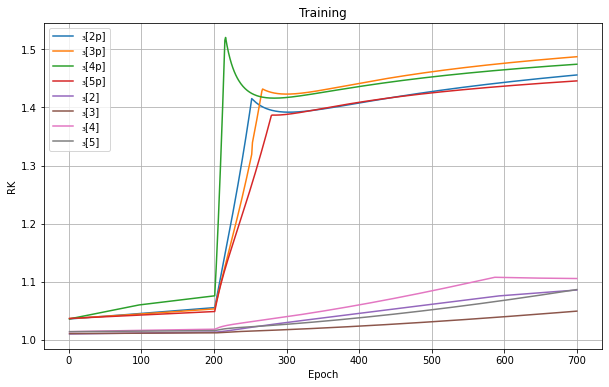

In [163]:
for name, logger in loggers.items():
    if results[name].n_outs != 3:
        continue 
    xs, Ws = logger.extract("W")
    plt.plot(xs, [rk_from_w(W) for W in Ws], label=name[1])
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("RK")
plt.legend()
plt.grid()
plt.show()

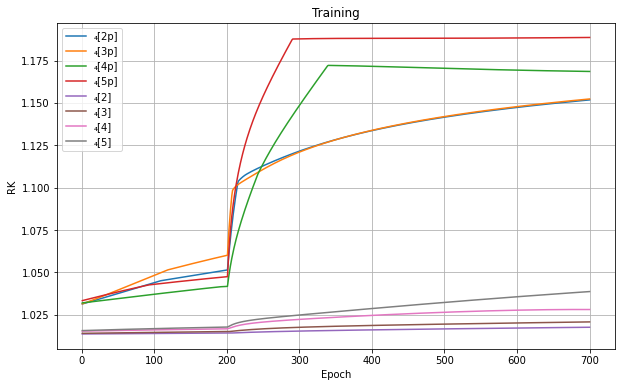

In [164]:
for name, logger in loggers.items():
    if results[name].n_outs != 4:
        continue 
    xs, Ws = logger.extract("W")
    plt.plot(xs, [rk_from_w(W) for W in Ws], label=name[1])
plt.title("Training")
plt.xlabel("Epoch")
plt.ylabel("RK")
plt.legend()
plt.grid()
plt.show()

### Result analysis

In [165]:
if False:
    fig, ax = plt.subplots(4, 2, figsize=(15, 30))
    for j, ds in enumerate(all_datasets):
        ax_ = ax[j//2, j%2]
        w = results[target_L, ds.name]
        sc = w.model[0]
        w_np = as_numpy(lambda x : w.model(x))
        feat = len(sc.features)
        if feat == 2:
            plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
        elif feat == 1:
            plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
    plt.show()

In [166]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [167]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [168]:
w_train = make_w(train_ds_notrue, results.values(), "train, w")
w_train

train, w        w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee             0.14916    0.326989    0.149568    0.341195    0.161351   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02        0.02        0.02   
B⁺→K⁺ψ(2S)(→ee)        0.01    0.012798        0.01    0.013287        0.01   
D⁺→π⁺φ(→ee)            0.07    0.891463        0.07    0.898907        0.07   

train, w        w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee            0.335412    0.175512    0.322219   0.036937   0.097382   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)    0.010692        0.01    0.013838   0.015366       0.01   
D⁺→π⁺φ(→ee)        0.916588        0.07    0.916924       0.07   0.553073   

train, w        w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           0.039916   0.066121   0.046732    0.11347   0.056486   
B⁺→K⁺J/ψ(→ee)         0.02       0.02       0.02       0.02       0.02   
B⁺→K⁺ψ(2S)(→ee)   0.014612   0.012196   0.016211   0.012255   0.013297   
D⁺→π⁺φ(→ee)           0.07   0.309836       0.07   0.533459       0.07   

train, w        w₃[5]@None  
B⁺→K⁺ee           0.098133  
B⁺→K⁺J/ψ(→ee)         0.02  
B⁺→K⁺ψ(2S)(→ee)   0.011959  
D⁺→π⁺φ(→ee)       0.411334

In [169]:
w_test = make_w(test_ds_notrue, results.values(), "test, w")
w_test

test, w         w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee            0.150041    0.326915    0.150346    0.341253    0.161929   
B⁺→K⁺J/ψ(→ee)      0.019775    0.019882    0.019788    0.019879    0.019786   
B⁺→K⁺ψ(2S)(→ee)    0.010012    0.012808    0.010011    0.013293    0.010025   
D⁺→π⁺φ(→ee)        0.069459    0.890755    0.069435    0.898133    0.069646   

test, w         w₃[4p]@None w₄[5p]@None w₃[5p]@None w₄[2]@None w₃[2]@None  \
B⁺→K⁺ee            0.335296    0.175699    0.321954   0.036945   0.097802   
B⁺→K⁺J/ψ(→ee)      0.019877    0.019811    0.019915   0.020096   0.020359   
B⁺→K⁺ψ(2S)(→ee)    0.010717    0.010014    0.013849   0.015342   0.009919   
D⁺→π⁺φ(→ee)        0.915753    0.070028    0.916212   0.070029   0.553142   

test, w         w₄[3]@None w₃[3]@None w₄[4]@None w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           0.039865   0.066312   0.046827   0.113858   0.056553   
B⁺→K⁺J/ψ(→ee)     0.020097   0.020232   0.019988    0.02021   0.020058   
B⁺→K⁺ψ(2S)(→ee)   0.014592   0.012143   0.016154   0.012202   0.013242   
D⁺→π⁺φ(→ee)           0.07   0.309716   0.070072   0.533339   0.070104   

test, w         w₃[5]@None  
B⁺→K⁺ee           0.098539  
B⁺→K⁺J/ψ(→ee)     0.020212  
B⁺→K⁺ψ(2S)(→ee)   0.011905  
D⁺→π⁺φ(→ee)       0.411037

In [170]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee            15.180283   45.614302   15.235586   48.754216   16.854642   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)      -1.0101   -0.729567     -1.0101    -0.68032   -1.010099   
D⁺→π⁺φ(→ee)         5.376345  802.915285    5.376346  869.405048    5.376345   

train, (R-1)*100  w₃[4p]@None w₄[5p]@None  w₃[5p]@None w₄[2]@None  w₃[2]@None  \
B⁺→K⁺ee             47.459853   18.861712    44.589498   1.758708    8.573066   
B⁺→K⁺J/ψ(→ee)             0.0         0.0          0.0        0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.940899   -1.010101    -0.624871  -0.470622   -1.010101   
D⁺→π⁺φ(→ee)       1074.884321    5.376346  1079.646962   5.376345  119.275416   

train, (R-1)*100 w₄[3]@None w₃[3]@None w₄[4]@None  w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee            2.074356   4.938648   2.804265   10.543383   3.867029   
B⁺→K⁺J/ψ(→ee)           0.0        0.0        0.0         0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.546821   -0.79003  -0.385174     -0.7841  -0.679308   
D⁺→π⁺φ(→ee)        5.376344  41.995206   5.376344  110.056349   5.376342   

train, (R-1)*100 w₃[5]@None  
B⁺→K⁺ee            8.663493  
B⁺→K⁺J/ψ(→ee)           0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.813863  
D⁺→π⁺φ(→ee)       66.478135

In [171]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee           15.326173    45.61583   15.365983   48.785678   16.960861   
B⁺→K⁺J/ψ(→ee)           0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.986167   -0.716499   -0.987655   -0.667555   -0.985984   
D⁺→π⁺φ(→ee)        5.339281  797.171126    5.335095  862.160913    5.359272   

test, (R-1)*100  w₃[4p]@None w₄[5p]@None  w₃[5p]@None w₄[2]@None  w₃[2]@None  \
B⁺→K⁺ee            47.452516   18.911636    44.545389   1.749579    8.583741   
B⁺→K⁺J/ψ(→ee)            0.0         0.0          0.0        0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.925907    -0.98955    -0.615146   -0.48279   -1.054552   
D⁺→π⁺φ(→ee)      1063.385299    5.399853  1069.721861   5.369368  119.228496   

test, (R-1)*100 w₄[3]@None w₃[3]@None w₄[4]@None  w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           2.058899   4.935303   2.815754   10.568031   3.868243   
B⁺→K⁺J/ψ(→ee)          0.0        0.0        0.0         0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)  -0.558631   -0.81878  -0.389622   -0.810666  -0.690728   
D⁺→π⁺φ(→ee)         5.3659  41.937071   5.385839  109.957725   5.381952   

test, (R-1)*100 w₃[5]@None  
B⁺→K⁺ee           8.688996  
B⁺→K⁺J/ψ(→ee)          0.0  
B⁺→K⁺ψ(2S)(→ee)  -0.840681  
D⁺→π⁺φ(→ee)        66.3581

In [172]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [173]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [174]:
map_all(compute_L, results, "L", dtype=float)

w₄[2p]@None    7.625384
w₃[2p]@None    6.502010
w₄[3p]@None    6.364623
w₃[3p]@None    7.631127
w₄[4p]@None    6.539946
w₃[4p]@None    7.395049
w₄[5p]@None    8.739245
w₃[5p]@None    9.200187
w₄[2]@None     0.166882
w₃[2]@None     1.155296
w₄[3]@None     0.210295
w₃[3]@None     0.527321
w₄[4]@None     1.009850
w₃[4]@None     3.315439
w₄[5]@None     1.407404
w₃[5]@None     1.960524
Name: L, dtype: float64

### L

In [175]:
%%time
L_results = dict()
if False:
    for target_L in [0.03, 0.10, 1.0, None]:
        ds = all_datasets[0]
        est = all_est[0]
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        L_results[target_L] = w

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 35.3 µs


In [176]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [177]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

Empty DataFrame
Columns: [L, RK train, RK test]
Index: []

### Conditional plots

In [178]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected_notrue:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [179]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    if sx == 1:
        ax = [ax]
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2][i%2])
    plt.show()   

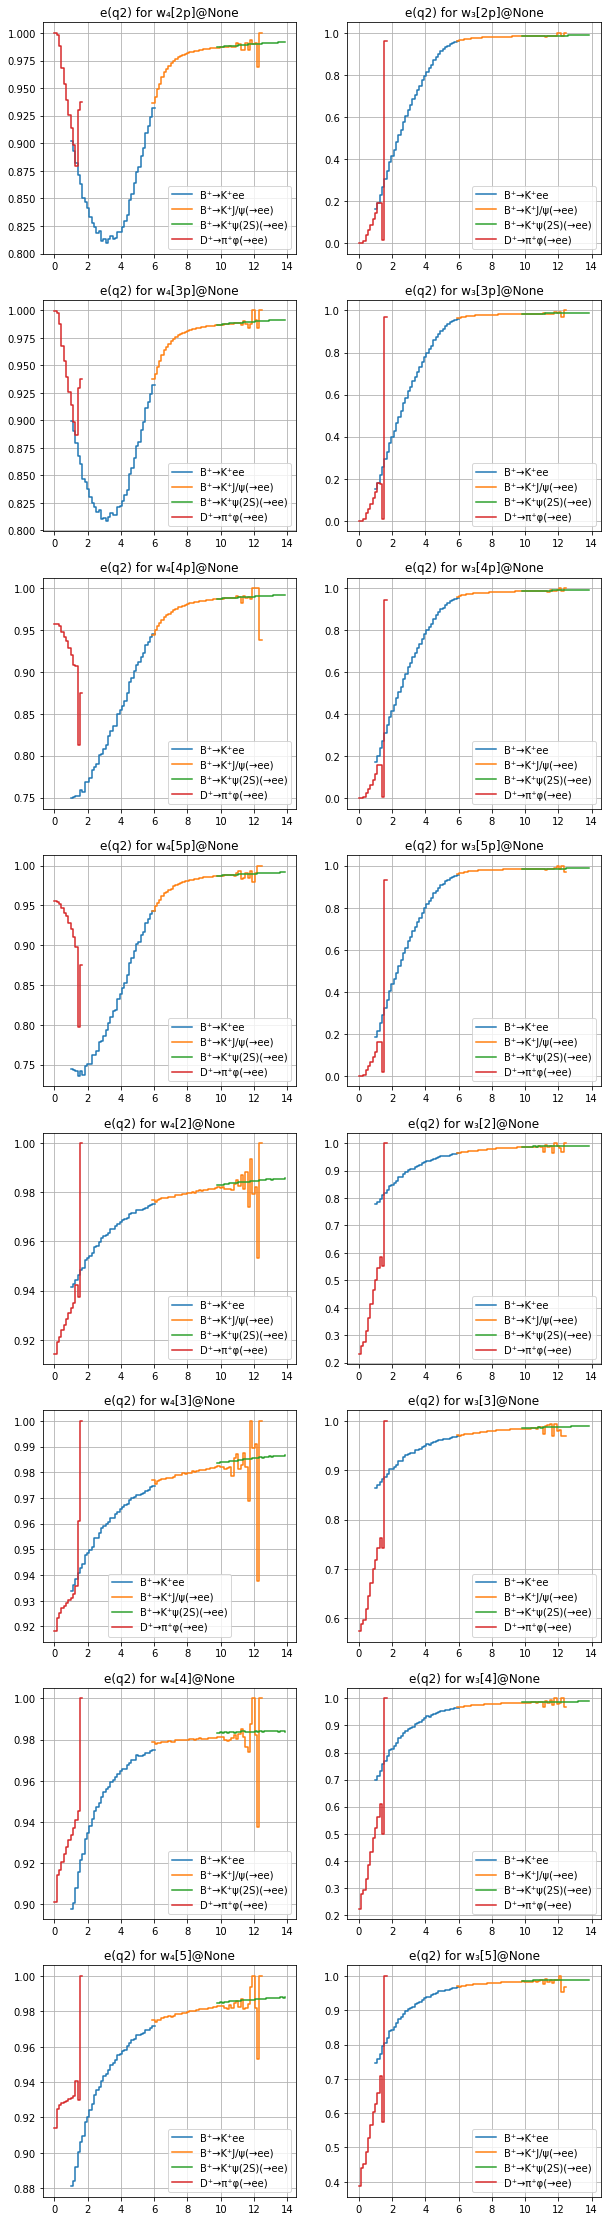

In [180]:
plot_e_all("q2", results, np.linspace(0,14,101))

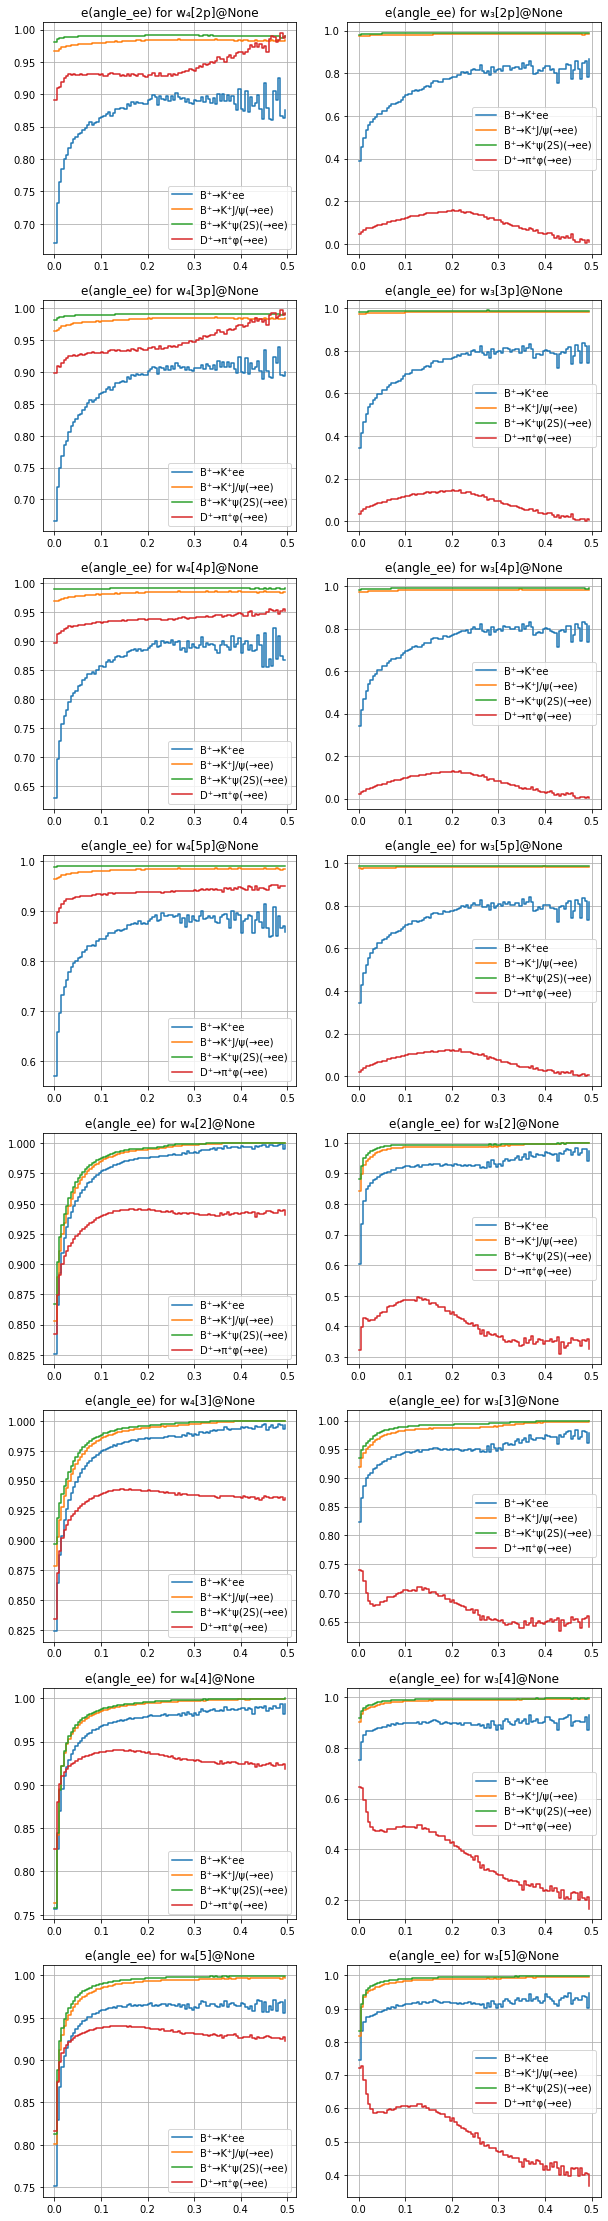

In [181]:
plot_e_all("angle_ee", results, np.linspace(0,0.5,101))

### 

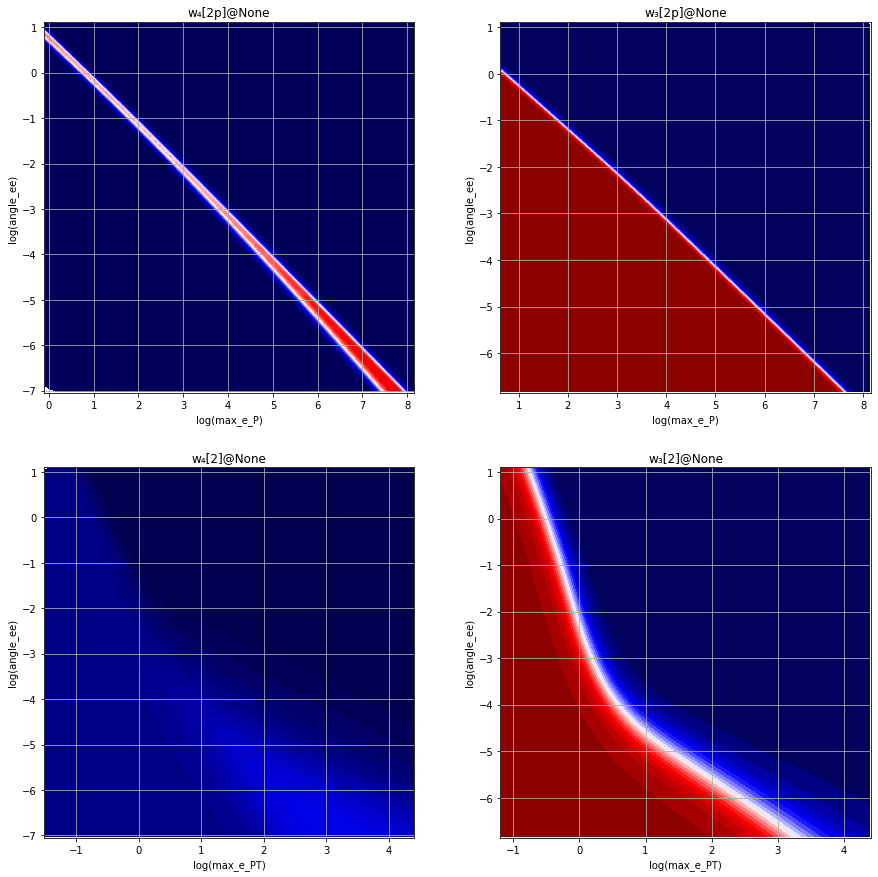

In [182]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for j, ds_i in enumerate([0,1,8,9]):
    ds = all_datasets[ds_i]
    ax_ = ax[j//2, j%2]
    w = results[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()

### Before and after training

In [183]:
def set_weights(m, dataset, n_classes=None, selected_class=0, **kwargs):
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    if n_classes is None:
        n_classes = len(dataset.sources)
    model = m.model
    n_outs = m.n_outs
    scaler = model[0]
    base = model[:3]
    linear = model[3]
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

In [184]:
results_initial = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w'%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        set_weights(w, ds)
        results_initial[target_L, ds.name] = w

In [185]:
wi_train = make_w(train_ds_notrue, results_initial.values(), "train, w'")
wi_test = make_w(test_ds_notrue, results_initial.values(), "test, w'")

In [186]:
wi_train

train, w'       w'₄[2p]@None w'₃[2p]@None w'₄[3p]@None w'₃[3p]@None  \
B⁺→K⁺ee             0.049789     0.053939     0.049828     0.054511   
B⁺→K⁺J/ψ(→ee)           0.02         0.02         0.02         0.02   
B⁺→K⁺ψ(2S)(→ee)     0.013104      0.01311     0.013251       0.0134   
D⁺→π⁺φ(→ee)             0.07     0.084337         0.07     0.085174   

train, w'       w'₄[4p]@None w'₃[4p]@None w'₄[5p]@None w'₃[5p]@None  \
B⁺→K⁺ee             0.050344     0.054022     0.051585     0.054673   
B⁺→K⁺J/ψ(→ee)           0.02         0.02         0.02         0.02   
B⁺→K⁺ψ(2S)(→ee)     0.012245      0.01274     0.011851     0.011994   
D⁺→π⁺φ(→ee)             0.07     0.084942         0.07     0.085369   

train, w'       w'₄[2]@None w'₃[2]@None w'₄[3]@None w'₃[3]@None w'₄[4]@None  \
B⁺→K⁺ee            0.033163    0.029657    0.033532    0.030313     0.03476   
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02        0.02        0.02   
B⁺→K⁺ψ(2S)(→ee)    0.015592    0.016591    0.015534    0.016388    0.015309   
D⁺→π⁺φ(→ee)            0.07    0.054487        0.07    0.054953        0.07   

train, w'       w'₃[4]@None w'₄[5]@None w'₃[5]@None  
B⁺→K⁺ee            0.033421    0.035058     0.03345  
B⁺→K⁺J/ψ(→ee)          0.02        0.02        0.02  
B⁺→K⁺ψ(2S)(→ee)    0.016209    0.015229    0.015972  
D⁺→π⁺φ(→ee)        0.056774        0.07     0.05672

In [187]:
wi_test

test, w'        w'₄[2p]@None w'₃[2p]@None w'₄[3p]@None w'₃[3p]@None  \
B⁺→K⁺ee             0.049812     0.053973     0.049847     0.054551   
B⁺→K⁺J/ψ(→ee)       0.019923     0.019924     0.019921     0.019919   
B⁺→K⁺ψ(2S)(→ee)     0.013112     0.013116     0.013256     0.013406   
D⁺→π⁺φ(→ee)         0.069954     0.084283     0.069952     0.085114   

test, w'        w'₄[4p]@None w'₃[4p]@None w'₄[5p]@None w'₃[5p]@None  \
B⁺→K⁺ee             0.050303     0.054005     0.051555     0.054643   
B⁺→K⁺J/ψ(→ee)       0.019914     0.019915     0.019909     0.019909   
B⁺→K⁺ψ(2S)(→ee)     0.012256     0.012752     0.011852     0.012002   
D⁺→π⁺φ(→ee)         0.069979      0.08491     0.069989     0.085345   

test, w'        w'₄[2]@None w'₃[2]@None w'₄[3]@None w'₃[3]@None w'₄[4]@None  \
B⁺→K⁺ee            0.033162    0.029649    0.033523    0.030287    0.034757   
B⁺→K⁺J/ψ(→ee)      0.020105    0.020067    0.020108    0.020076    0.020101   
B⁺→K⁺ψ(2S)(→ee)     0.01557    0.016574    0.015514    0.016374    0.015287   
D⁺→π⁺φ(→ee)         0.07002    0.054503    0.070009    0.054956    0.070002   

test, w'        w'₃[4]@None w'₄[5]@None w'₃[5]@None  
B⁺→K⁺ee            0.033448    0.035077    0.033486  
B⁺→K⁺J/ψ(→ee)      0.020053    0.020098    0.020048  
B⁺→K⁺ψ(2S)(→ee)    0.016184    0.015196     0.01594  
D⁺→π⁺φ(→ee)        0.056771    0.069997     0.05671

In [188]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[2p]@None w₃[2p]@None w₄[3p]@None w₃[3p]@None w₄[4p]@None  \
B⁺→K⁺ee           15.326173    45.61583   15.365983   48.785678   16.960861   
B⁺→K⁺J/ψ(→ee)           0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.986167   -0.716499   -0.987655   -0.667555   -0.985984   
D⁺→π⁺φ(→ee)        5.339281  797.171126    5.335095  862.160913    5.359272   

test, (R-1)*100  w₃[4p]@None w₄[5p]@None  w₃[5p]@None w₄[2]@None  w₃[2]@None  \
B⁺→K⁺ee            47.452516   18.911636    44.545389   1.749579    8.583741   
B⁺→K⁺J/ψ(→ee)            0.0         0.0          0.0        0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.925907    -0.98955    -0.615146   -0.48279   -1.054552   
D⁺→π⁺φ(→ee)      1063.385299    5.399853  1069.721861   5.369368  119.228496   

test, (R-1)*100 w₄[3]@None w₃[3]@None w₄[4]@None  w₃[4]@None w₄[5]@None  \
B⁺→K⁺ee           2.058899   4.935303   2.815754   10.568031   3.868243   
B⁺→K⁺J/ψ(→ee)          0.0        0.0        0.0         0.0        0.0   
B⁺→K⁺ψ(2S)(→ee)  -0.558631   -0.81878  -0.389622   -0.810666  -0.690728   
D⁺→π⁺φ(→ee)         5.3659  41.937071   5.385839  109.957725   5.381952   

test, (R-1)*100 w₃[5]@None  
B⁺→K⁺ee           8.688996  
B⁺→K⁺J/ψ(→ee)          0.0  
B⁺→K⁺ψ(2S)(→ee)  -0.840681  
D⁺→π⁺φ(→ee)        66.3581

In [189]:
make_R(1-wi_test, "test, (R'-1)*100")

test, (R'-1)*100 w'₄[2p]@None w'₃[2p]@None w'₄[3p]@None w'₃[3p]@None  \
B⁺→K⁺ee               3.14565     3.599133     3.149641     3.663026   
B⁺→K⁺J/ψ(→ee)             0.0          0.0          0.0          0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.690133    -0.689777    -0.675438    -0.660185   
D⁺→π⁺φ(→ee)          5.379438     7.028302     5.379385     7.126021   

test, (R'-1)*100 w'₄[4p]@None w'₃[4p]@None w'₄[5p]@None w'₃[5p]@None  \
B⁺→K⁺ee              3.199841     3.603514      3.33669      3.67415   
B⁺→K⁺J/ψ(→ee)             0.0          0.0          0.0          0.0   
B⁺→K⁺ψ(2S)(→ee)     -0.775362    -0.725606    -0.815328    -0.800303   
D⁺→π⁺φ(→ee)          5.383111      7.10249     5.384949     7.154093   

test, (R'-1)*100 w'₄[2]@None w'₃[2]@None w'₄[3]@None w'₃[3]@None w'₄[4]@None  \
B⁺→K⁺ee             1.350499    0.987426    1.387968    1.052928    1.518372   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.460649   -0.355206    -0.46663   -0.376422    -0.48882   
D⁺→π⁺φ(→ee)         5.367305    3.642066    5.365664    3.690824    5.365743   

test, (R'-1)*100 w'₃[4]@None w'₄[5]@None w'₃[5]@None  
B⁺→K⁺ee             1.385769     1.55236    1.390318  
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0  
B⁺→K⁺ψ(2S)(→ee)    -0.393313   -0.497823   -0.417459  
D⁺→π⁺φ(→ee)         3.892769      5.3655    3.886613

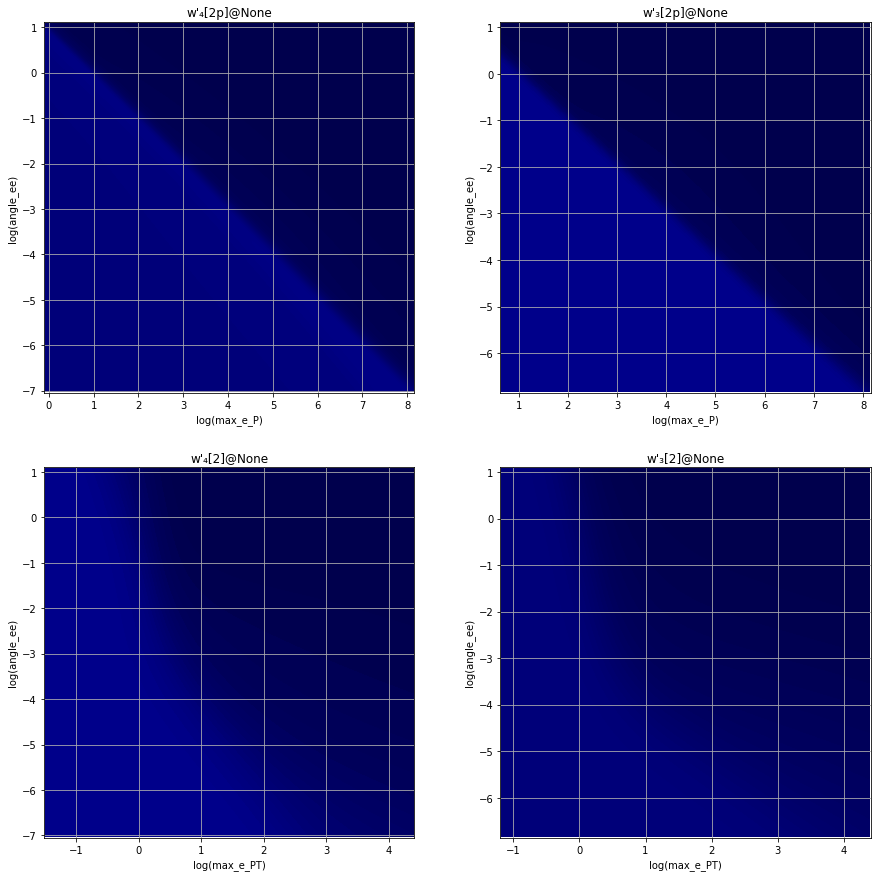

In [190]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for j, ds_i in enumerate([0,1,8,9]):
    ds = all_datasets[ds_i]
    ax_ = ax[j//2, j%2]
    w = results_initial[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()